<a href="https://colab.research.google.com/github/Rakeshscode/Data-Science/blob/main/Unit5Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm

from scipy.interpolate import PchipInterpolator

How does Hepatitis B immunization coverage
among 1-year-olds affect life expectancy in developing countries?

In [4]:
#load the data into a pandas dataframe, and print it
url_lf = 'https://raw.githubusercontent.com/Rakeshscode/Data-Science/refs/heads/main/Life%20Expectancy%20Data.csv'
#I could have put the url string directly into pd.read_csv()
data = pd.read_csv(url_lf)
data = data.dropna()
data

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,Developing,44.3,723.0,27,4.36,0.000000,68.0,31,...,67.0,7.13,65.0,33.6,454.366654,12777511.0,9.4,9.4,0.407,9.2
2934,Zimbabwe,2003,Developing,44.5,715.0,26,4.06,0.000000,7.0,998,...,7.0,6.52,68.0,36.7,453.351155,12633897.0,9.8,9.9,0.418,9.5
2935,Zimbabwe,2002,Developing,44.8,73.0,25,4.43,0.000000,73.0,304,...,73.0,6.53,71.0,39.8,57.348340,125525.0,1.2,1.3,0.427,10.0
2936,Zimbabwe,2001,Developing,45.3,686.0,25,1.72,0.000000,76.0,529,...,76.0,6.16,75.0,42.1,548.587312,12366165.0,1.6,1.7,0.427,9.8


<Axes: xlabel='Life expectancy ', ylabel='Hepatitis B'>

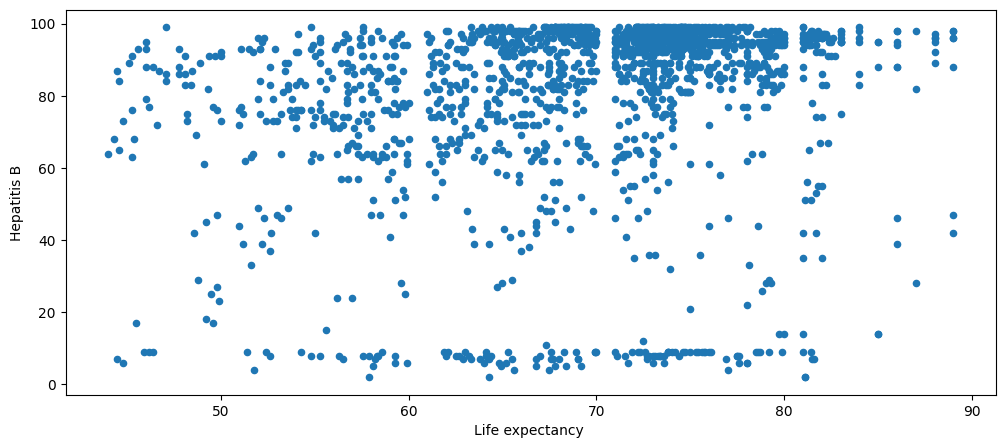

In [5]:
#scatter plot of life expectancy v. hepatitis B
data.plot(x="Life expectancy ", y="Hepatitis B", figsize=(12, 5), kind="scatter")

In [6]:
#lf stands for life expectancy
with pm.Model() as model_lf:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + β * data["Life expectancy "])

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfCauchy("σ", 10)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=data["Hepatitis B"])

    #inference data object
    idata_lf = pm.sample()

Output()

Output()

Text(0, 0.5, 'Hepatitis B')

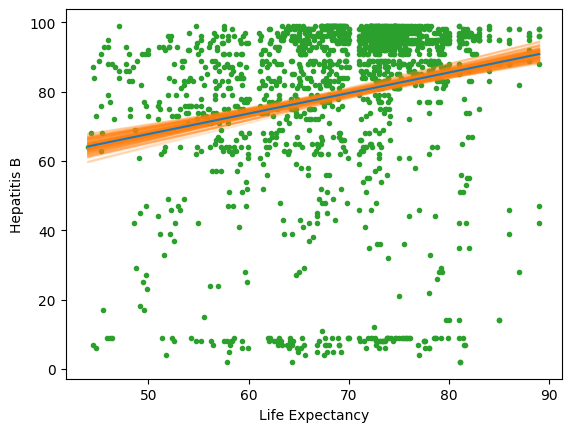

In [7]:
#grabs 100 posterior samples
posterior = az.extract(idata_lf, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(data["Life expectancy "].min(), data["Life expectancy "].max(), 50),
    dims="plot_id"
    )

# this creates the expected line, the path we predict Life Expectancy and
#hepatitis b c deviates from
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(data['Life expectancy '] , data['Hepatitis B'], "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("Life Expectancy")
ax.set_ylabel("Hepatitis B")

In [8]:
# posterior predictive check
pm.sample_posterior_predictive(idata_lf, model=model_lf,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'Hepatitis B')

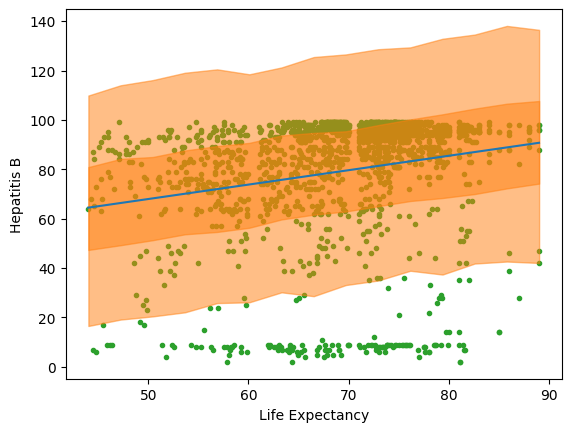

In [9]:
#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_lf.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
life_expectancies = np.random.normal(data['Life expectancy '].values, 0.01)
idx = np.argsort(life_expectancies)
x = np.linspace(life_expectancies.min(), life_expectancies.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_lf.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(life_expectancies[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(data["Life expectancy "] , data["Hepatitis B"], "C2.", zorder=-3)
ax.plot(data["Life expectancy "].to_numpy()[idx], mean_line.to_numpy()[idx], c="C0")

#graphs the 94% and 50% HDIs
for lf, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lf, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("Life Expectancy")
ax.set_ylabel("Hepatitis B")

<Axes: xlabel='y_pred'>

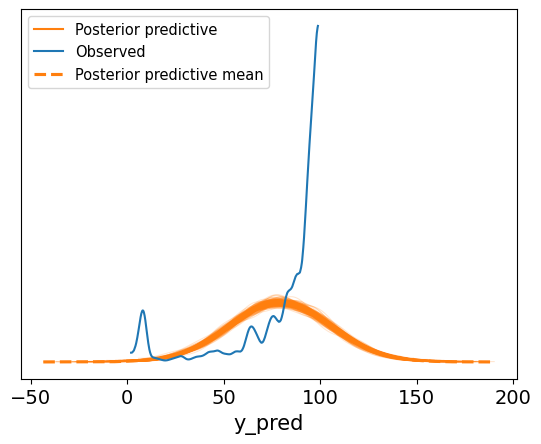

In [10]:
#posterior predictive check
az.plot_ppc(idata_lf, num_pp_samples=200, colors=["C1", "C0", "C1"])

This fits pretty terribly. I've updated the model to use a Beta likelihood, scaling "Hepatitis B" data to the [0, 1] range and applying a logistic link function. This should better match the observed data.

In [11]:
# Use the original variables provided by the user
data_life_expectancy = data["Life expectancy "]
data_hepatitis_b = data["Hepatitis B"].dropna()

# Normalize Life Expectancy for better convergence
data_life_expectancy = (data_life_expectancy - data_life_expectancy.mean()) / data_life_expectancy.std()

with pm.Model() as nb_model:
    # Priors for intercept and slope
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)

    # Linear predictor with logistic link function for Beta likelihood
    mu = pm.Deterministic("mu", pm.math.sigmoid(alpha + beta * data_life_expectancy))

    # Beta likelihood (requires data in range [0, 1])
    y_pred = pm.Beta(
        "y_pred",
        alpha=mu * 10,  # Shape parameter 1 (scaled by a factor for flexibility)
        beta=(1 - mu) * 10,  # Shape parameter 2
        observed=data_hepatitis_b / 100  # Scale Hepatitis B to [0, 1]
    )

    # Sample from the posterior
    nb_trace = pm.sample()

Output()

Output()

In [12]:
pm.sample_posterior_predictive(nb_trace, model = nb_model, extend_inferencedata=True)


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y_pred'>

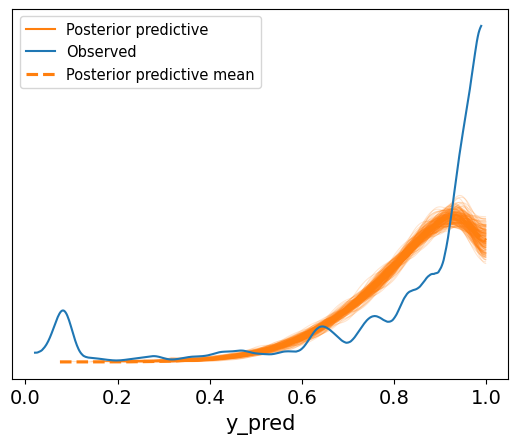

In [13]:
az.plot_ppc(nb_trace, num_pp_samples=200, colors=["C1", "C0", "C1"])

To improve the fit further, we can adjust the Beta likelihood's flexibility by introducing priors for the shape parameters' scaling factor instead of using a fixed value like 10. Additionally, we can refine the priors for the slope and intercept to reflect any domain knowledge or observed data trends. I'll make these changes. I've updated the model to include a prior for the Beta likelihood's scaling factor (kappa), making the shape parameters more flexible. Additionally, the priors for the intercept and slope have been tightened to improve stability and fit.

In [14]:
# Use the original variables provided by the user
data_life_expectancy = data["Life expectancy "]
data_hepatitis_b = data["Hepatitis B"].dropna()

# Normalize Life Expectancy for better convergence
data_life_expectancy = (data_life_expectancy - data_life_expectancy.mean()) / data_life_expectancy.std()

with pm.Model() as nb_model:
    # Priors for intercept and slope
    alpha = pm.Normal("alpha", mu=0, sigma=5)  # Adjusted prior for intercept
    beta = pm.Normal("beta", mu=0, sigma=5)  # Adjusted prior for slope

    # Prior for scaling factor of Beta shape parameters
    kappa = pm.Gamma("kappa", alpha=2, beta=0.5)

    # Linear predictor with logistic link function for Beta likelihood
    mu = pm.Deterministic("mu", pm.math.sigmoid(alpha + beta * data_life_expectancy))

    # Beta likelihood (requires data in range [0, 1])
    y_pred = pm.Beta(
        "y_pred",
        alpha=mu * kappa,  # Shape parameter 1 (scaled by kappa)
        beta=(1 - mu) * kappa,  # Shape parameter 2
        observed=data_hepatitis_b / 100  # Scale Hepatitis B to [0, 1]
    )

    # Sample from the posterior
    nb_trace = pm.sample()

Output()

Output()

In [15]:
pm.sample_posterior_predictive(nb_trace, model = nb_model, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y_pred'>

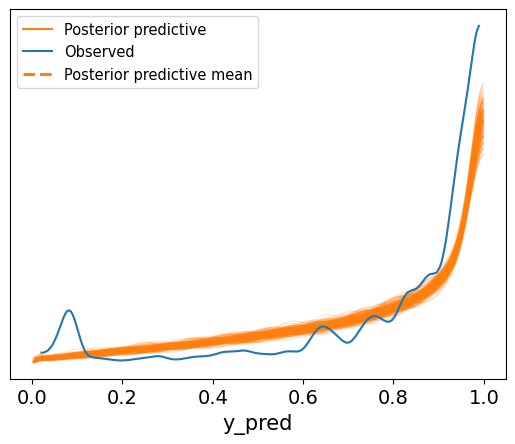

In [16]:
az.plot_ppc(nb_trace, num_pp_samples=200, colors=["C1", "C0", "C1"])

In [20]:
with pm.Model() as model_hp:
    # Priors for the line for our mean
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)

    # Priors for the line for our standard deviation
    gamma = pm.HalfNormal("gamma", sigma=10)
    delta = pm.HalfNormal("delta", sigma=10)

    # Mean line
    mu = pm.Deterministic("mu", pm.math.sigmoid(alpha + beta * data_life_expectancy))

    # Standard deviation line; allows variance to vary over x values
    sigma = pm.Deterministic("sigma", gamma + delta * data_life_expectancy)

    # Normal likelihood with variable variance
    y_pred = pm.Normal("y_pred", mu=mu, sigma=sigma, observed=data_hepatitis_b / 100)  # Scaled Hepatitis B to [0, 1]

    # Sample from the posterior
    data_vb = pm.sample()



Output()

Output()

ERROR:pymc.stats.convergence:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


In [21]:
pm.sample_posterior_predictive(data_vb, model = model_hp, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'Hepatitis B (scaled to [0, 1])')

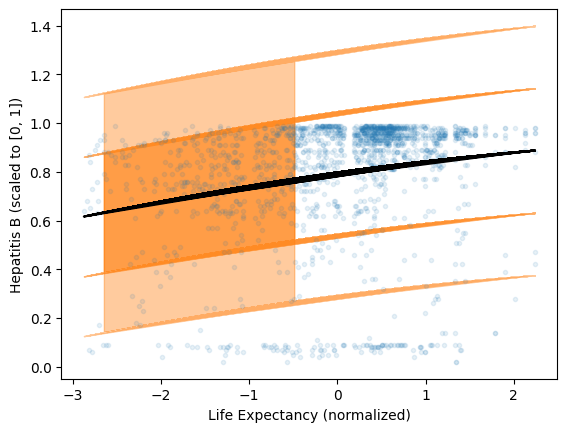

In [22]:
# Plots the posterior

_, ax = plt.subplots()

# Plot the raw data points
ax.plot(data_life_expectancy, data_hepatitis_b / 100, "C0.", alpha=0.1)

# Extract posterior samples
posterior_vvba = az.extract(data_vb)

# Compute the means for μ and σ from posterior samples
μ_m = posterior_vvba["mu"].mean("sample").values
σ_m = posterior_vvba["sigma"].mean("sample").values

# Plot the mean line
ax.plot(data_life_expectancy, μ_m, c="k")

# Plot the 1σ and 2σ credible intervals
ax.fill_between(data_life_expectancy, μ_m + 1 * σ_m, μ_m - 1 * σ_m, alpha=0.6, color="C1")
ax.fill_between(data_life_expectancy, μ_m + 2 * σ_m, μ_m - 2 * σ_m, alpha=0.4, color="C1")

# Label axes
ax.set_xlabel("Life Expectancy (normalized)")
ax.set_ylabel("Hepatitis B (scaled to [0, 1])")


The results indicate a positive correlation between Hepatitis B immunization coverage among 1-year-olds and life expectancy in developing countries. The black line (posterior mean) shows that as life expectancy increases, immunization coverage generally trends higher. This relationship highlights the role of improved healthcare systems and vaccination programs in countries with longer life expectancy.

However, the variability (orange shaded credible intervals) is significant, especially at lower life expectancy levels. The wider intervals and scattered data points in this range suggest inconsistent immunization coverage, likely due to resource limitations, infrastructure challenges, or socio-economic disparities in developing regions.

The clustering of points at higher immunization coverage (0.6–1.0) for many countries suggests successful implementation of vaccination programs in regions with moderate to high life expectancy. Overall, the results underscore the importance of expanding immunization efforts in lower life expectancy countries to improve health outcomes and support broader longevity gains.